In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [3]:
from masa_utils import PsuedoLog
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Pelton, ColeCole, Debye_Sum_Ser_f, Debye_Sum_Par_f
from masa_utils_pytorch import Optimization

# Observation uses Cole-Cole model

In [4]:
res0= 0.2
con8 = 10.0
eta= 0.5
expc= 0.5
tau= 0.1 #0.001
taupel = tau
taucc = tau*(1-eta)**(1/expc)
print(f"time constant, Pelton:{taupel:.2e}, Cole-Cole: {taucc:.2e}")

time constant, Pelton:1.00e-01, Cole-Cole: 2.50e-02


In [5]:
#pelton model
tau_true=0.1
parm_true = torch.tensor([np.log(res0), eta, np.log(taupel),expc], dtype=torch.float) #, requires_grad=False)
# inital reference model
np_mvec_true = parm_true.detach().numpy()# cole model


In [6]:
nfreq = 61
freqstrt_log = -1
freqend_log = 5
freq = np.logspace(freqstrt_log, freqend_log, nfreq)
freq_plot = freq
print(freq.shape)
print(freq)

(61,)
[1.00000000e-01 1.25892541e-01 1.58489319e-01 1.99526231e-01
 2.51188643e-01 3.16227766e-01 3.98107171e-01 5.01187234e-01
 6.30957344e-01 7.94328235e-01 1.00000000e+00 1.25892541e+00
 1.58489319e+00 1.99526231e+00 2.51188643e+00 3.16227766e+00
 3.98107171e+00 5.01187234e+00 6.30957344e+00 7.94328235e+00
 1.00000000e+01 1.25892541e+01 1.58489319e+01 1.99526231e+01
 2.51188643e+01 3.16227766e+01 3.98107171e+01 5.01187234e+01
 6.30957344e+01 7.94328235e+01 1.00000000e+02 1.25892541e+02
 1.58489319e+02 1.99526231e+02 2.51188643e+02 3.16227766e+02
 3.98107171e+02 5.01187234e+02 6.30957344e+02 7.94328235e+02
 1.00000000e+03 1.25892541e+03 1.58489319e+03 1.99526231e+03
 2.51188643e+03 3.16227766e+03 3.98107171e+03 5.01187234e+03
 6.30957344e+03 7.94328235e+03 1.00000000e+04 1.25892541e+04
 1.58489319e+04 1.99526231e+04 2.51188643e+04 3.16227766e+04
 3.98107171e+04 5.01187234e+04 6.30957344e+04 7.94328235e+04
 1.00000000e+05]


In [7]:
IP_model = Pelton(freq=freq)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")

In [8]:
dobs_clean=sim.dpred(parm_true).detach()
f_abs = abs(IP_model.f(parm_true)).detach().numpy()
print(f_abs.max(),f_abs.min())
relative_error = torch.tensor(0.02)

noise_floor = torch.tensor(f_abs.max() * 1e-3)
torch.random.seed()
dobs =  dobs_clean + torch.rand(len(dobs_clean)) * torch.sqrt(
        (relative_error * abs(dobs_clean))**2 
        + (noise_floor*torch.ones(len(dobs_clean)))**2
    )

0.18348786 0.10028248


# But Invert using Cole-Cole model

In [9]:
IP_model = ColeCole(freq=freq,res=True)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
parm_init = torch.tensor([np.log(5), 0.1, np.log(0.04), 0.6], dtype=torch.float32, requires_grad=True) #, requires_grad=False)

In [10]:
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
# opt.Wd = torch.diag(torch.ones(len(dobs)))
opt.Ws = torch.eye(4)

In [11]:
print(torch.diag(opt.Wd))

tensor([ 271.3402,  270.4564,  277.0822,  279.3459,  285.8570,  285.1819,
         290.3479,  295.8208,  303.9995,  308.0043,  317.0667,  324.8643,
         330.0350,  335.4923,  347.5970,  354.1187,  363.8310,  366.2059,
         374.3074,  384.3759,  394.9141,  402.3504,  407.5683,  415.4445,
         420.5260,  431.3466,  434.1450,  439.1131,  442.4597,  449.6782,
         449.8768,  456.7319,  458.8979,  466.7418,  471.4742,  470.9283,
         475.8418,  478.8343,  472.7429,  481.4252,  478.4612,  477.8786,
         482.5455,  482.7683,  484.3608,  481.1085,  484.4311,  486.7561,
         486.1112,  486.7943,  486.0209,  492.6227,  487.1199,  489.6632,
         488.6010,  493.0158,  494.6072,  489.7392,  487.4128,  487.8870,
         490.4385, 3274.6826, 3095.1777, 2965.3823, 2802.9304, 2692.6489,
        2592.2329, 2493.9556, 2409.9373, 2338.0891, 2299.0383, 2237.2898,
        2226.0244, 2211.4475, 2250.5798, 2253.8601, 2295.8450, 2354.6272,
        2395.2163, 2500.9680, 2593.406

In [12]:
niter = 200
stol=1e-6
coolingFactor = 2.0
coolingRate = 2
mu=1e-3
beta0_ratio = 1

In [13]:
models_rec = []
dpreds = []
errors_prg = []
models_prg = []
dinit_refs = []

In [14]:
beta0 = opt.BetaEstimate_byEig(
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
print(beta0)
mpred = opt.GradientDescent(stol=stol,l1reg=True,
coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
    mvec_init=parm_init,niter=niter,beta0=beta0,
    update_Wsen=True,ELS=True, BLS=True)
dinit_refs.append(opt.dpred(parm_init))
models_rec.append(mpred)
dpreds.append(opt.dpred(mpred))
errors_prg.append(opt.error_prg)
models_prg.append(opt.mvec_prg)

tensor(7.1795e+08)


  1, beta:7.2e+08, step:9.5e-07, gradient:2.1e+05,  f:6.2e+04
  2, beta:7.2e+08, step:9.5e-07, gradient:9.8e+08,  f:2.5e+06
  3, beta:3.6e+08, step:1.9e-06, gradient:4.9e+08,  f:6.4e+04
  4, beta:3.6e+08, step:9.5e-07, gradient:4.9e+08,  f:6.8e+05
  5, beta:1.8e+08, step:1.9e-06, gradient:2.5e+08,  f:6.4e+04
  6, beta:1.8e+08, step:9.5e-07, gradient:2.5e+08,  f:2.2e+05
  7, beta:9.0e+07, step:1.9e-06, gradient:1.2e+08,  f:6.3e+04
  8, beta:9.0e+07, step:9.5e-07, gradient:1.2e+08,  f:1.0e+05
  9, beta:4.5e+07, step:1.9e-06, gradient:6.2e+07,  f:6.2e+04
 10, beta:4.5e+07, step:9.5e-07, gradient:6.1e+07,  f:7.0e+04
 11, beta:2.2e+07, step:1.9e-06, gradient:3.1e+07,  f:6.2e+04
 12, beta:2.2e+07, step:9.5e-07, gradient:3.1e+07,  f:6.3e+04
 13, beta:1.1e+07, step:1.9e-06, gradient:1.6e+07,  f:6.2e+04
 14, beta:1.1e+07, step:9.5e-07, gradient:1.5e+07,  f:6.2e+04
 15, beta:5.6e+06, step:1.9e-06, gradient:7.9e+06,  f:6.1e+04
 16, beta:5.6e+06, step:9.5e-07, gradient:7.5e+06,  f:6.1e+04
 17, bet

In [15]:
np_mvec_prg = opt.mvec_prg
np_mvec_init = parm_init.detach().numpy()
np_mvec_true = parm_true.detach().numpy()
np_mvec_est = mpred.detach().numpy()
dest = opt.dpred(mpred)

In [16]:
print("Note we are using Cole-Cole model for simulation")
print( "Parameter:     con8,   chg,       tau,     c")

print(f"initial :{np.exp(np_mvec_init[0]):.2e}, {np_mvec_init[1]:3f}, {np.exp(np_mvec_init[2]):.2e}, {np_mvec_init[3]:.3f}")
print(f"est     :{np.exp(np_mvec_est[0]):.2e}, { np_mvec_est[1]:3f}, { np.exp(np_mvec_est[2]):.2e}, { np_mvec_est[3]:.3f}")

print("But we are using Pelton model for observation")
print(f"est     :{np.exp(-np_mvec_est[0])/(1.0-np_mvec_est[1]):.2e}, { np_mvec_est[1]:3f}, { np.exp(np_mvec_est[2]):.2e}, { np_mvec_est[3]:.3f}")
print(f"true    :{np.exp(np_mvec_true[0]):.2e}, {np_mvec_true[1]:3f}, {np.exp(np_mvec_true[2]):.3e}, {np_mvec_true[3]:.3f}")


Note we are using Cole-Cole model for simulation
Parameter:     con8,   chg,       tau,     c
initial :5.00e+00, 0.100000, 4.00e-02, 0.600
est     :9.77e+00, 0.488337, 2.96e-02, 0.504
But we are using Pelton model for observation
est     :2.00e-01, 0.488337, 2.96e-02, 0.504
true    :2.00e-01, 0.500000, 1.000e-01, 0.500


In [17]:
eta = np_mvec_true[1]
c = np_mvec_true[3]
taup = np.exp(np_mvec_true[2])
tauc = np.exp(np_mvec_est[2])
print((1-eta)*(taup**c))
print((tauc**c))

0.15811388194561005
0.17208248


# Invert with DDR

In [18]:
ntau=11
taus = np.logspace(-4,1,ntau)
print(taus)

[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01]


In [19]:
IP_model = Debye_Sum_Ser_f(freq=freq, taus=taus)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")

In [20]:
parm_init = torch.tensor(
    np.r_[np.log(0.22), np.zeros(ntau)],
    dtype=torch.float32,
    requires_grad=True
) #, requires_grad=False)


In [21]:
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
opt.Ws = torch.eye(len(parm_init))
beta0 = opt.BetaEstimate_byEig(
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)

In [22]:
beta0 = opt.BetaEstimate_byEig(
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
print(beta0)
mpred = opt.GradientDescent(stol=stol,l1reg=True,
coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
    mvec_init=parm_init,niter=niter,beta0=beta0,
    update_Wsen=True,ELS=True, BLS=True)
dinit_refs.append(opt.dpred(parm_init))
models_rec.append(mpred)
dpreds.append(opt.dpred(mpred))
errors_prg.append(opt.error_prg)
models_prg.append(opt.mvec_prg)

tensor(53758812.)
  1, beta:5.4e+07, step:9.5e-07, gradient:1.2e+06,  f:9.3e+04
  2, beta:5.4e+07, step:3.8e-06, gradient:1.3e+08,  f:9.3e+04
  3, beta:2.7e+07, step:9.5e-07, gradient:1.1e+07,  f:9.4e+04
  4, beta:2.7e+07, step:3.1e-05, gradient:6.4e+07,  f:9.3e+04
  5, beta:1.3e+07, step:9.5e-07, gradient:5.4e+06,  f:9.3e+04
  6, beta:1.3e+07, step:3.1e-05, gradient:3.1e+07,  f:9.3e+04
  7, beta:6.7e+06, step:9.5e-07, gradient:2.8e+06,  f:9.3e+04
  8, beta:6.7e+06, step:6.1e-05, gradient:1.5e+07,  f:9.3e+04
  9, beta:3.4e+06, step:9.5e-07, gradient:2.0e+06,  f:9.3e+04
 10, beta:3.4e+06, step:6.1e-05, gradient:7.1e+06,  f:9.3e+04
 11, beta:1.7e+06, step:9.5e-07, gradient:1.2e+06,  f:9.3e+04
 12, beta:1.7e+06, step:1.2e-04, gradient:3.0e+06,  f:9.3e+04
 13, beta:8.4e+05, step:9.5e-07, gradient:1.1e+06,  f:9.3e+04
 14, beta:8.4e+05, step:1.2e-04, gradient:1.0e+06,  f:9.3e+04
 15, beta:4.2e+05, step:2.5e-01, gradient:1.1e+06,  f:9.0e+04
 16, beta:4.2e+05, step:1.0e+00, gradient:4.3e+05,  

# Invert DDC 

In [23]:
IP_model = Debye_Sum_Par_f(freq=freq, taus=taus, res=True)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")

In [24]:
parm_init = torch.tensor(
    np.r_[np.log(5.0), np.zeros(ntau)],
    dtype=torch.float32,
    requires_grad=True
) #, requires_grad=False)


In [25]:
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
opt.Ws = torch.eye(len(parm_init))


In [26]:
beta0 = opt.BetaEstimate_byEig(
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
print(beta0)
mpred = opt.GradientDescent(stol=stol,l1reg=True,
coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
    mvec_init=parm_init,niter=niter,beta0=beta0,
    update_Wsen=True,ELS=True, BLS=True)
dinit_refs.append(opt.dpred(parm_init))
models_rec.append(mpred)
dpreds.append(opt.dpred(mpred))
errors_prg.append(opt.error_prg)
models_prg.append(opt.mvec_prg)

tensor(7.1348e+08)
  1, beta:7.1e+08, step:9.5e-07, gradient:3.9e+05,  f:7.3e+04
  2, beta:7.1e+08, step:9.5e-07, gradient:1.3e+09,  f:9.1e+04
  3, beta:3.6e+08, step:9.5e-07, gradient:1.5e+08,  f:1.1e+05
  4, beta:3.6e+08, step:7.6e-06, gradient:6.7e+08,  f:7.4e+04
  5, beta:1.8e+08, step:9.5e-07, gradient:7.3e+07,  f:8.3e+04
  6, beta:1.8e+08, step:1.5e-05, gradient:3.4e+08,  f:8.0e+04
  7, beta:8.9e+07, step:1.9e-06, gradient:3.6e+07,  f:7.4e+04
  8, beta:8.9e+07, step:7.6e-06, gradient:1.7e+08,  f:7.3e+04
  9, beta:4.5e+07, step:9.5e-07, gradient:1.8e+07,  f:7.3e+04
 10, beta:4.5e+07, step:7.6e-06, gradient:8.4e+07,  f:7.3e+04
 11, beta:2.2e+07, step:9.5e-07, gradient:9.3e+06,  f:7.3e+04
 12, beta:2.2e+07, step:1.5e-05, gradient:4.2e+07,  f:7.3e+04
 13, beta:1.1e+07, step:1.9e-06, gradient:4.7e+06,  f:7.2e+04
 14, beta:1.1e+07, step:7.6e-06, gradient:2.1e+07,  f:7.2e+04
 15, beta:5.6e+06, step:9.5e-07, gradient:2.5e+06,  f:7.2e+04
 16, beta:5.6e+06, step:7.6e-06, gradient:1.0e+07, 

In [27]:
nref= 3

In [28]:
dest_abs_np =[]
dest_phase_np =[]
dest_real_np =[]
dest_imag_np =[]
dinit_abs_np =[]
dinit_phase_np =[]
mpred_np =[]
for i in range(nref):
    mpred_np.append(models_rec[i].detach().numpy())
    dest = dpreds[i].detach().numpy()
    dinit = dinit_refs[i].detach().numpy()
    dest_real = dest[:nfreq]
    dest_imag = dest[nfreq:]
    dinit_real = dinit[:nfreq]
    dinit_imag = dinit[nfreq:]
    dest_abs = np.abs(dest_real + 1j * dest_imag)
    dest_phase = np.angle(dest_real + 1j * dest_imag, deg=True)
    dinit_abs = np.abs(dinit_real + 1j * dinit_imag) 
    dinit_phase = np.angle(dinit_real + 1j * dinit_imag, deg=True)
    dest_real_np.append(dest_real)
    dest_imag_np.append(dest_imag)
    dest_abs_np.append(dest_abs)
    dest_phase_np.append(dest_phase)
    dinit_abs_np.append(dinit_abs)
    dinit_phase_np.append(dinit_phase)
dobs_np = dobs.detach().numpy()
dobs_real = dobs_np[:nfreq]
dobs_imag = dobs_np[nfreq:]
dobs_abs = np.abs(dobs_real + 1j * dobs_imag)
dobs_phase = np.angle(dobs_real + 1j * dobs_imag, deg=True)


In [29]:
print( "Parameter:     res0,   chg")
for i in range(1,nref):
    np_mvec_est = mpred_np[i]
    # print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1:].sum():.3f} ")
    print(f"est{i+1}     & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1:].sum():.3f}")


Parameter:     res0,   chg
est2     & 2.04e-01 & 0.499
est3     & 9.79e+00 & 0.475


In [30]:

np_mvec_est = mpred_np[1]
res0_ddr = np.exp(np_mvec_est[0])
eta_ddr = np_mvec_est[1:].sum()
np_mvec_est = mpred_np[2]
con8_ddc = np.exp(np_mvec_est[0])
eta_ddc = np_mvec_est[1:].sum()
res0_ddc= 1/(1-eta_ddc)/con8_ddc

print(f"rho_ddr: {res0_ddr:.2e}, eta_ddr: {eta_ddr:.3f}")
print(f"con8_ddc: {con8_ddc:.2e}, res0_ddc:{res0_ddc:.2e} eta_ddc: {eta_ddc:.3f}")


rho_ddr: 2.04e-01, eta_ddr: 0.499
con8_ddc: 9.79e+00, res0_ddc:1.95e-01 eta_ddc: 0.475


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


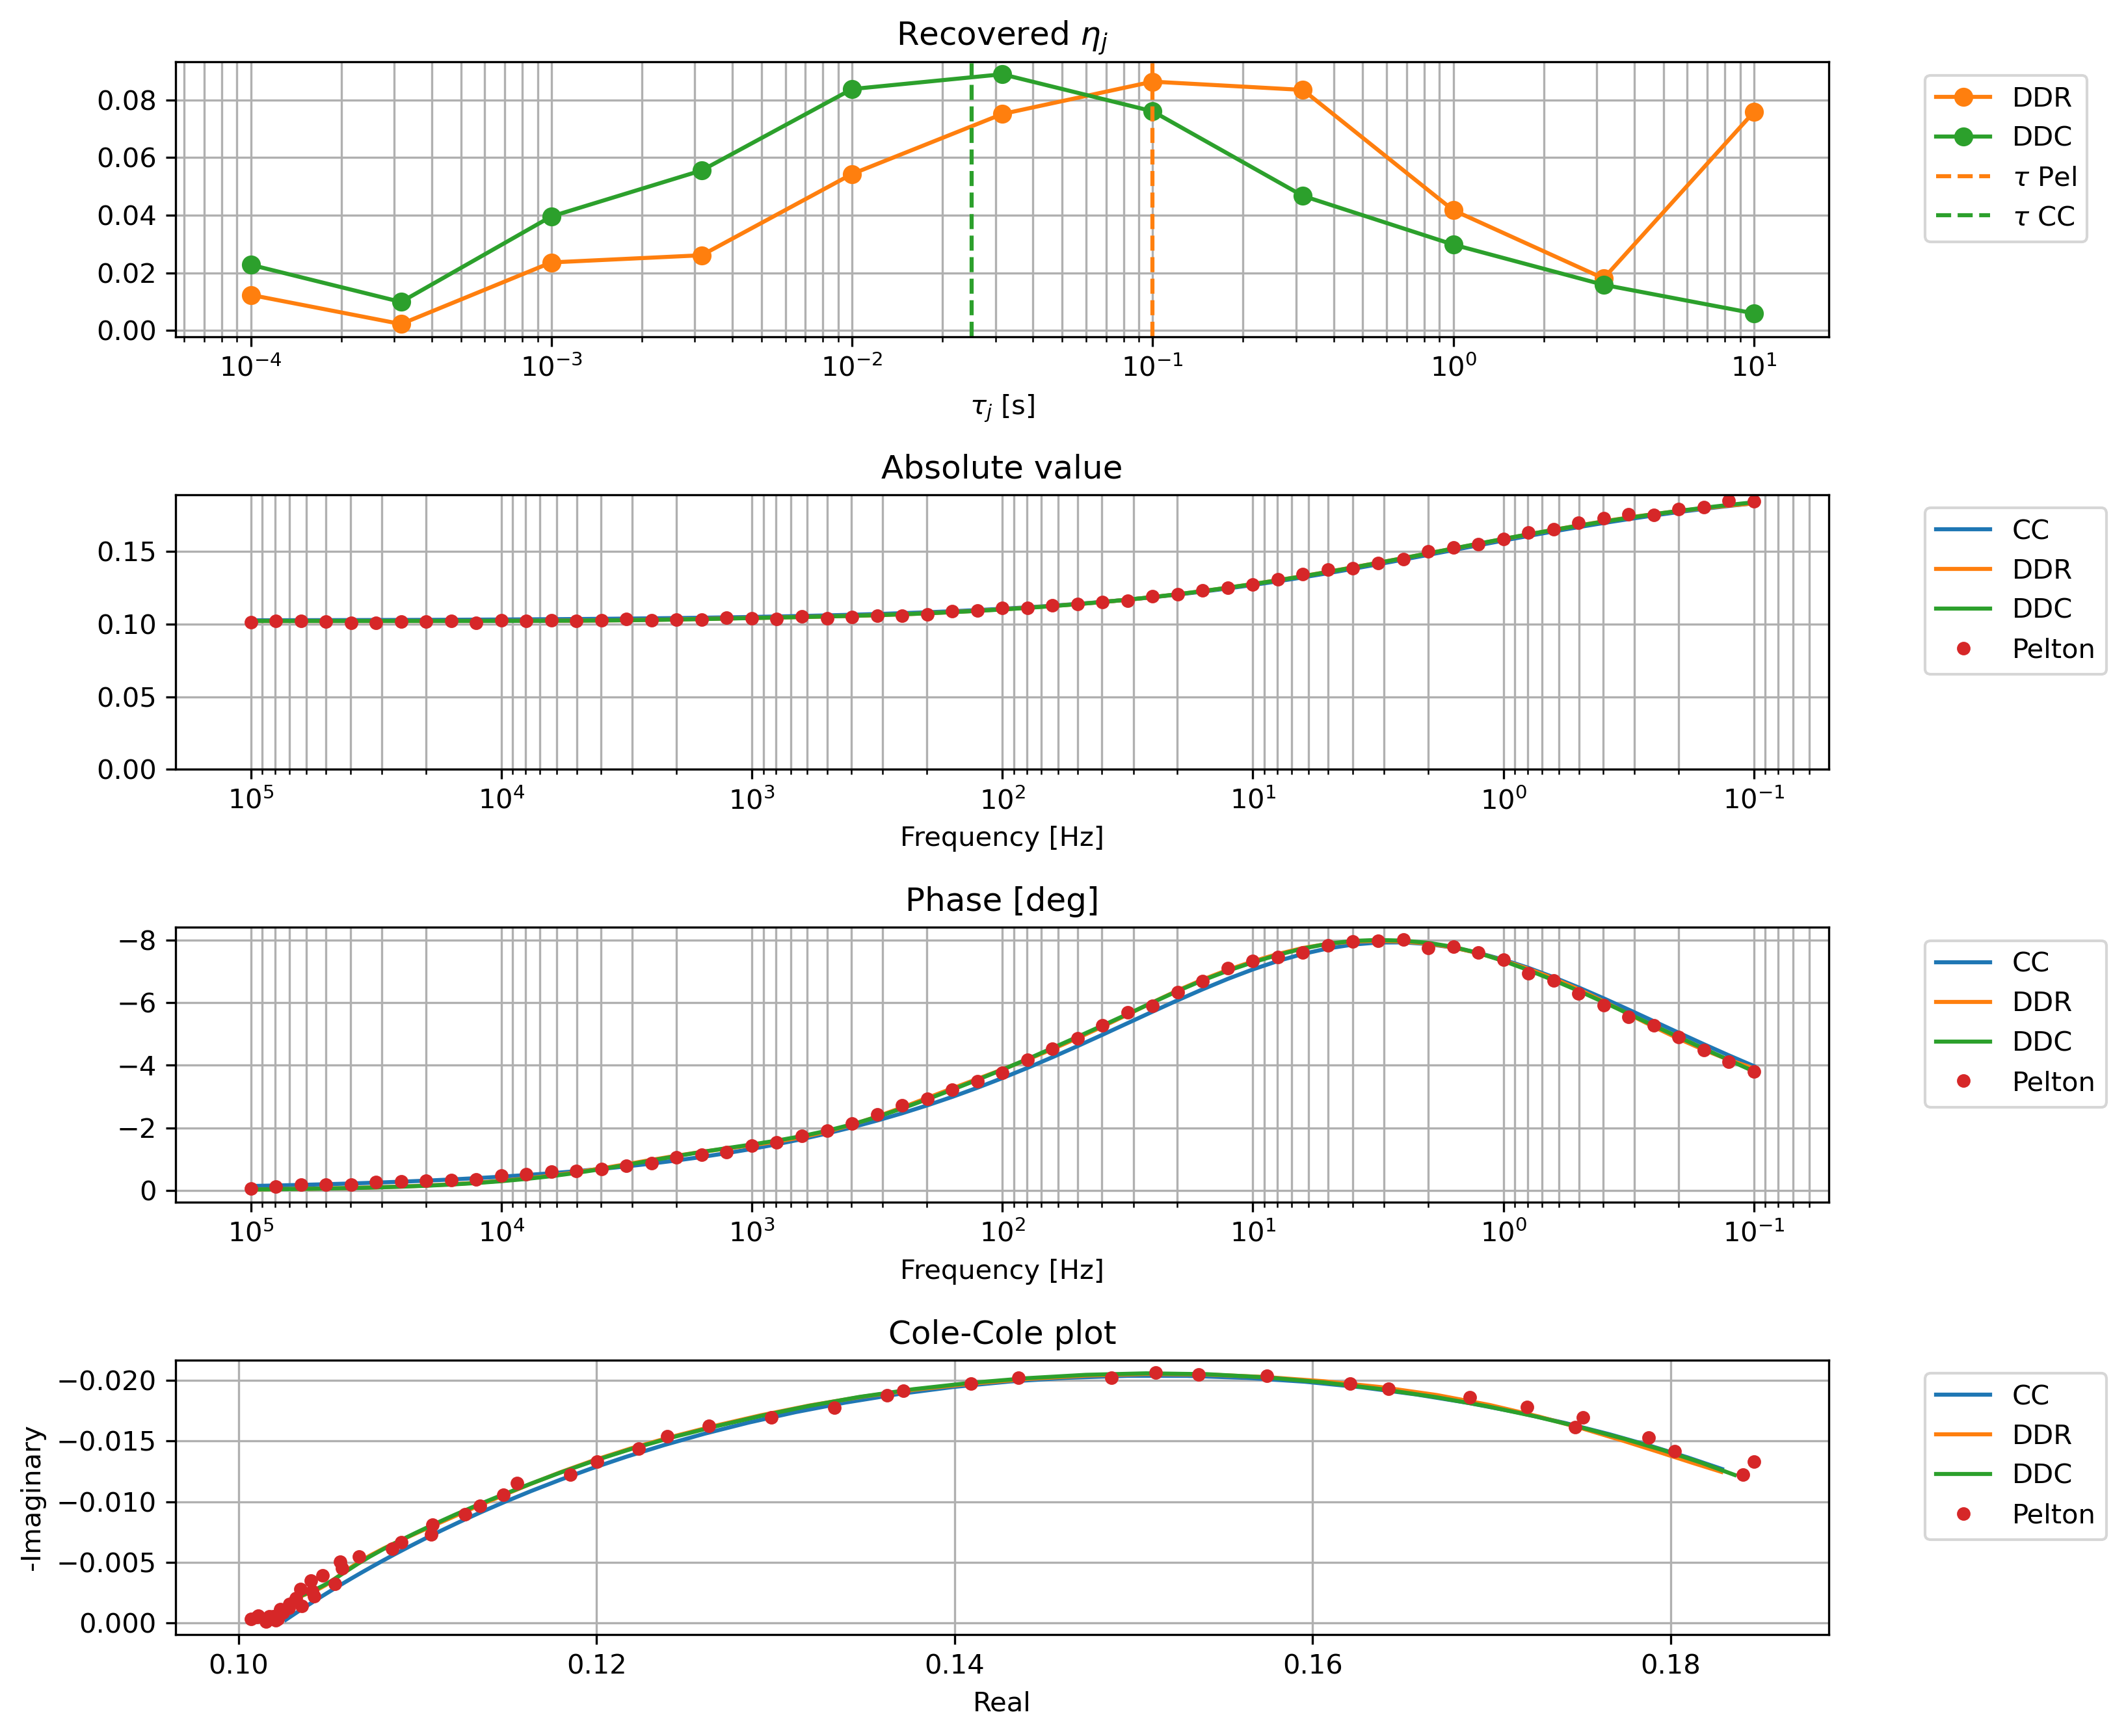

In [31]:
fig, ax = plt.subplots(4, 1, figsize=(11,9),dpi=300)
labels = ['CC', 'DDR', 'DDC']
for i in range(nref):
    dest_abs = dest_abs_np[i]
    dest_phase = dest_phase_np[i]
    dest_real = dest_real_np[i]
    dest_imag = dest_imag_np[i]
    dinit_abs = dinit_abs_np[i] 
    dinit_phase = dinit_phase_np[i]
    mpred_plot = mpred_np[i]
    if i !=0:
        ax[0].semilogx(taus, mpred_plot[1:1+ntau], color=f"C{i}",  marker="o",label=labels[i])
    ax[1].semilogx(freq_plot, dest_abs, color=f"C{i}", label=labels[i])
    # ax[1].semilogx(freq_plot, dinit_abs, color=f"C{i}", linestyle="--", label=+1}")
    ax[2].semilogx(freq_plot, dest_phase, color=f"C{i}", label=labels[i])
    # ax[2].semilogx(freq_plot, dinit_phase, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[3].plot(dest_real, dest_imag, color=f"C{i}", label=labels[i])
ax[0].axvline(x=taupel, color="C1", linestyle="--", label=r"$\tau$ Pel")
ax[0].axvline(x=taucc, color="C2", linestyle="--", label=r"$\tau$ CC")
ax[1].semilogx(freq_plot, dobs_abs, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="Pelton")
ax[1].set_ylim(bottom=0)
ax[1].invert_xaxis()
ax[2].semilogx(freq_plot, dobs_phase, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="Pelton")
ax[2].invert_xaxis()
ax[2].invert_yaxis()
ax[3].plot(dobs_real, dobs_imag, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="Pelton")
ax[3].invert_yaxis()

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_xlabel(r"$\tau_j$ [s]")
ax[0].set_title(r"Recovered $\eta_j$")
ax[1].set_title("Absolute value")
ax[2].set_title("Phase [deg]")
ax[3].set_title("Cole-Cole plot")
ax[3].set_xlabel("Real")
ax[3].set_ylabel("-Imaginary")
plt.tight_layout()
plt.savefig("32_SIP_Pel_CC_DDR_DDC.jpg", dpi=300)

In [32]:
print( "Parameter:     res0,   chg")


print(f"est      & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1:].sum():.3f}")
print(f"true     & {np.exp(np_mvec_true[0]):.2e} & {np_mvec_true[1]:.3f} & {np.exp(np_mvec_true[2]):.2e} & {np_mvec_true[3]:.3f}")

Parameter:     res0,   chg
est      & 9.79e+00 & 0.475
true     & 2.00e-01 & 0.500 & 1.00e-01 & 0.500
